# Introduction to xarray with Dask Parallization for Earth Data

This notebook covers the basics of using Dask for parallel computing with NASA Earthdata completely in the cloud. That is, the data are access in the cloud, as well as analyzed in the cloud. 

### When should Dask be used?
...

...

### Two classes of use cases for parallel computing covered here
In the author's experience, parallelizing most Earthdata analyses will fall into one of two categrories, and determining which one is the first step. 
1. The first type is an analysis which simply needs to be replicated many times, e.g. performing the same analysis on 1000 different files. This is typically easier to wrap one's head around, as well as more straightforward to implement with Dask, or other parallel computing methods for that matter (see e.g. Lambda functions in a separate section of the PO.DAAC cookbook).
2. The second type is for analyses which are not trivially replicated over parts of a single file or multiple files. For example, taking 1000 files, where each file corresponds to a separate time stamp, and computing the mean and standard deviation over time (producing e.g. a 2D lon/lat map of means and standard deviations), falls into this category. This is because to compute the mean over time, you need to grab parts of the data set from all 1000 files. Another example is an empirical orthogonal function (EOF) analysis. This is an analysis which needs to be performed on the entire 3D dataset as a whole, not simple 2D slices of it. This, in the author's opinion, is a little more difficult to conceptualize as well as to implement. It requires you to understand chunking and sharpen your NumPy and Xarray syntax.

In this notebook, we cover very basic examples of implementing both cases 1 and 2 with Dask. In two subsequent notebooks, we show more complex examples of each, mirroring more realistic scenarios that a scientist/research might find themselves in. However, in both cases the underlying ideas covered in this notebook will be the foundation of the workflows.

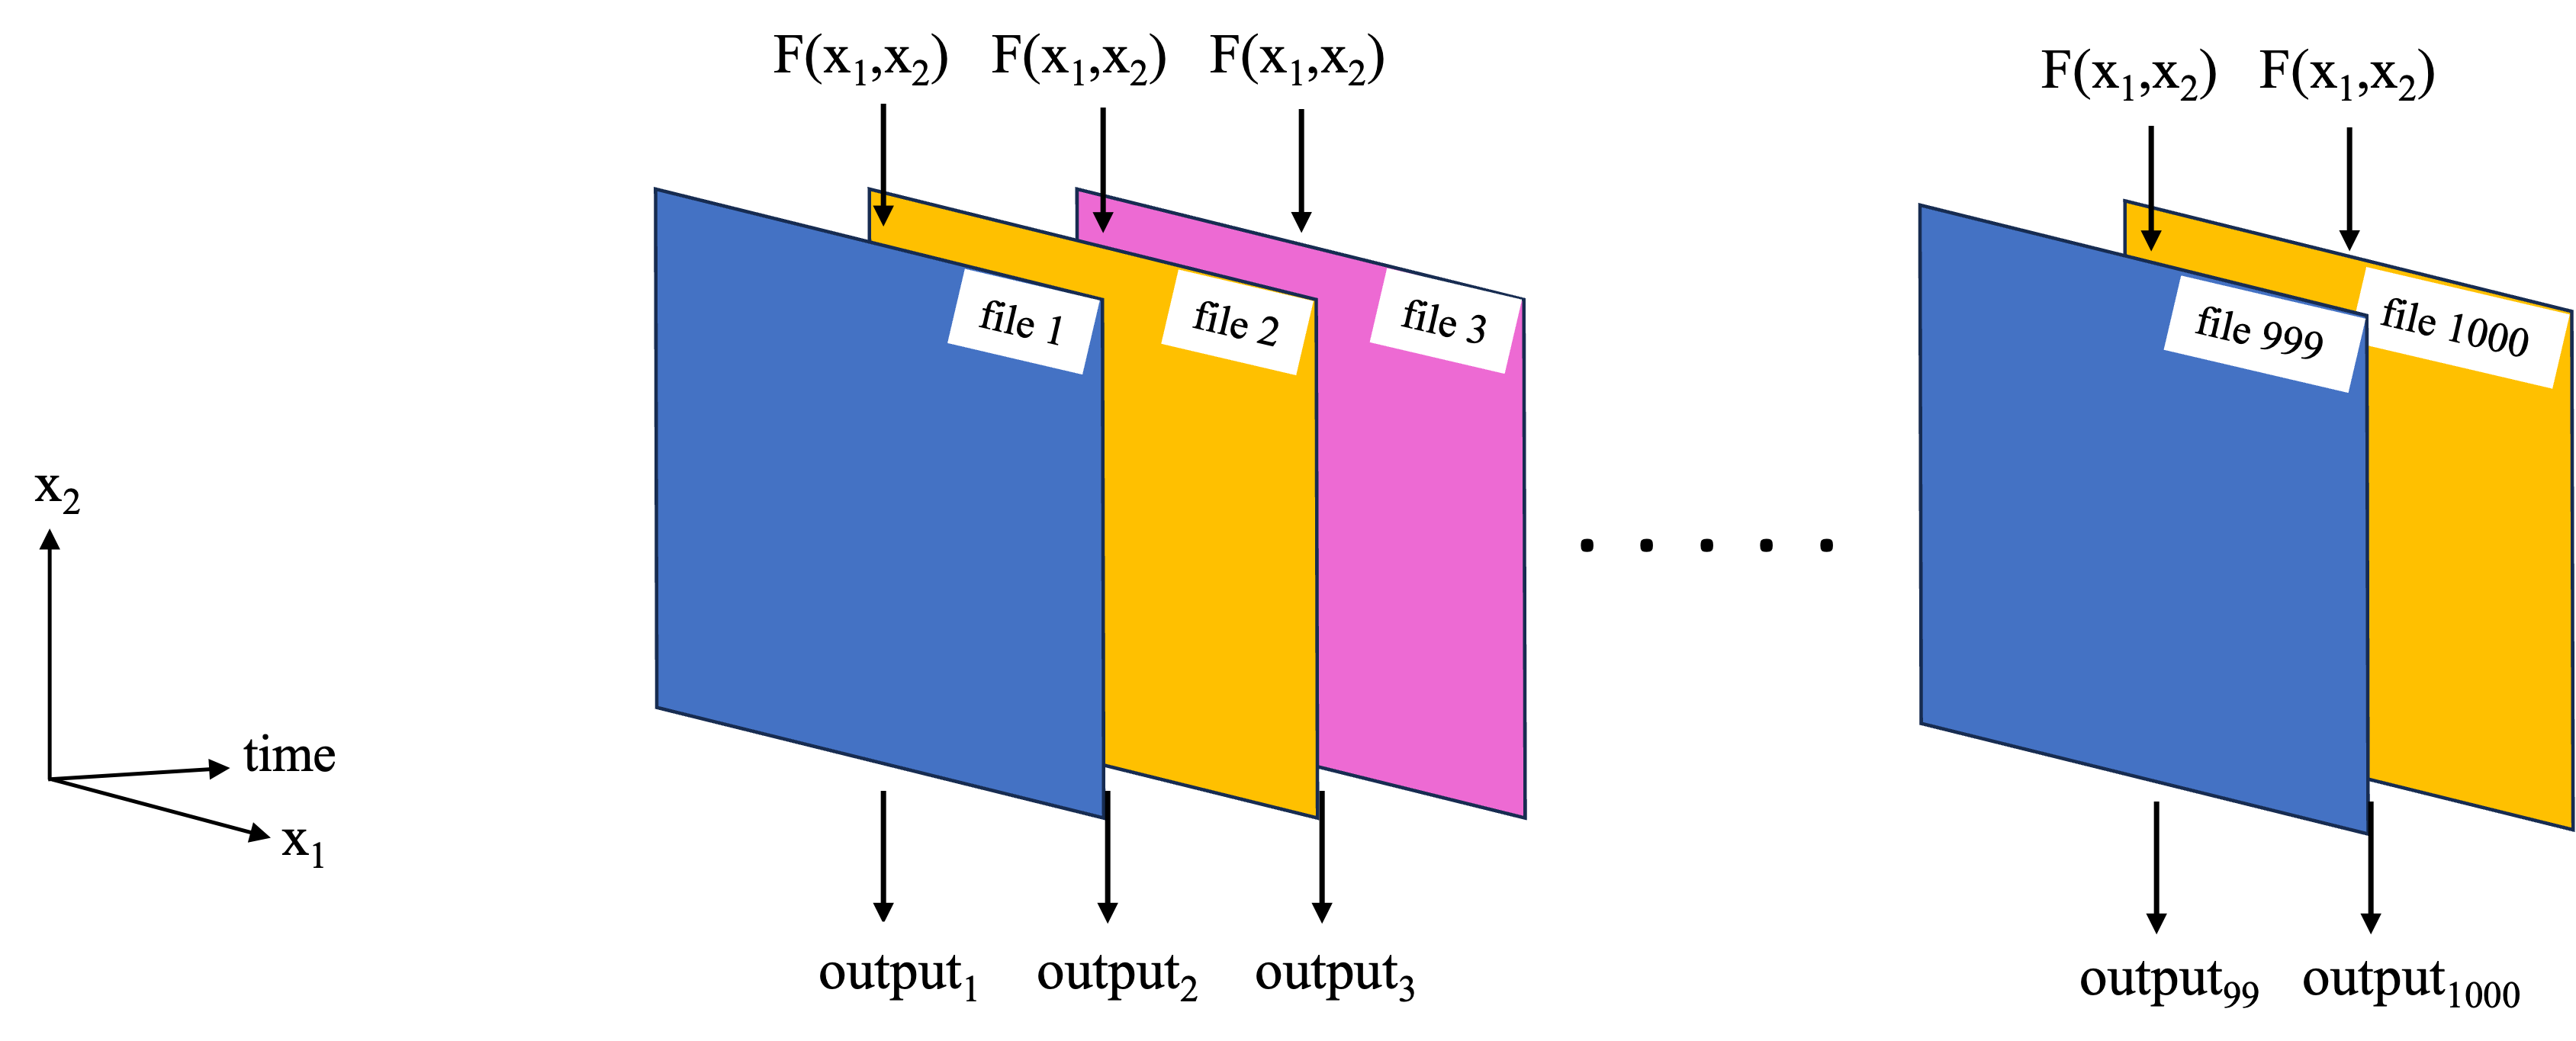

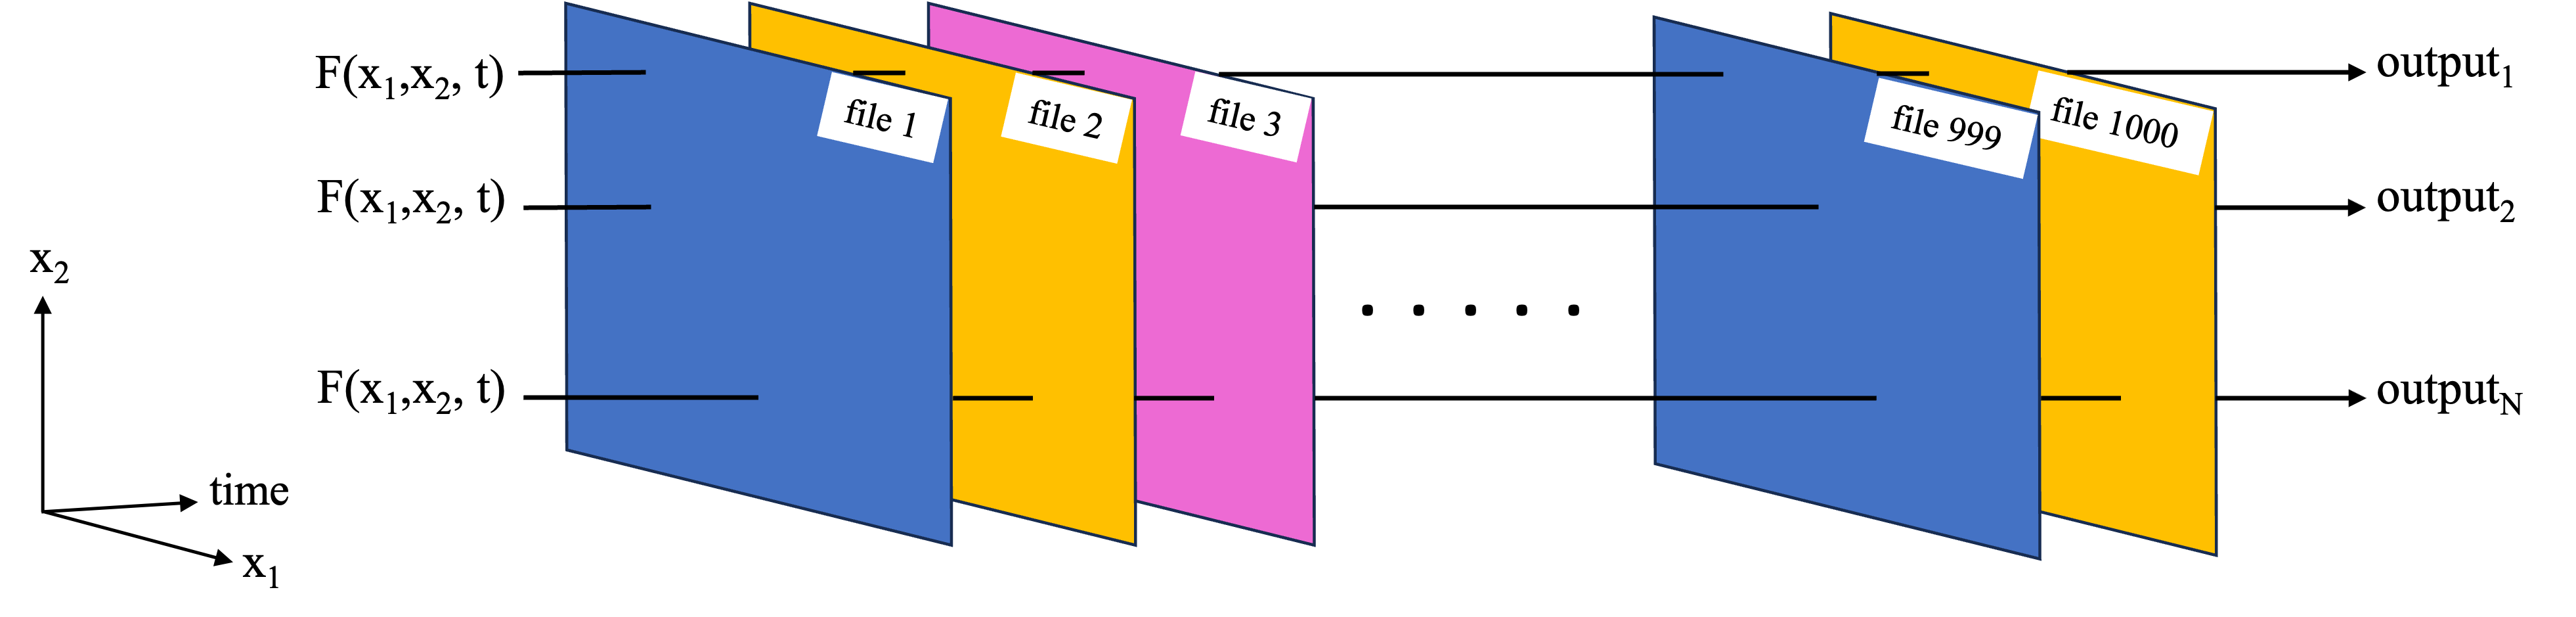

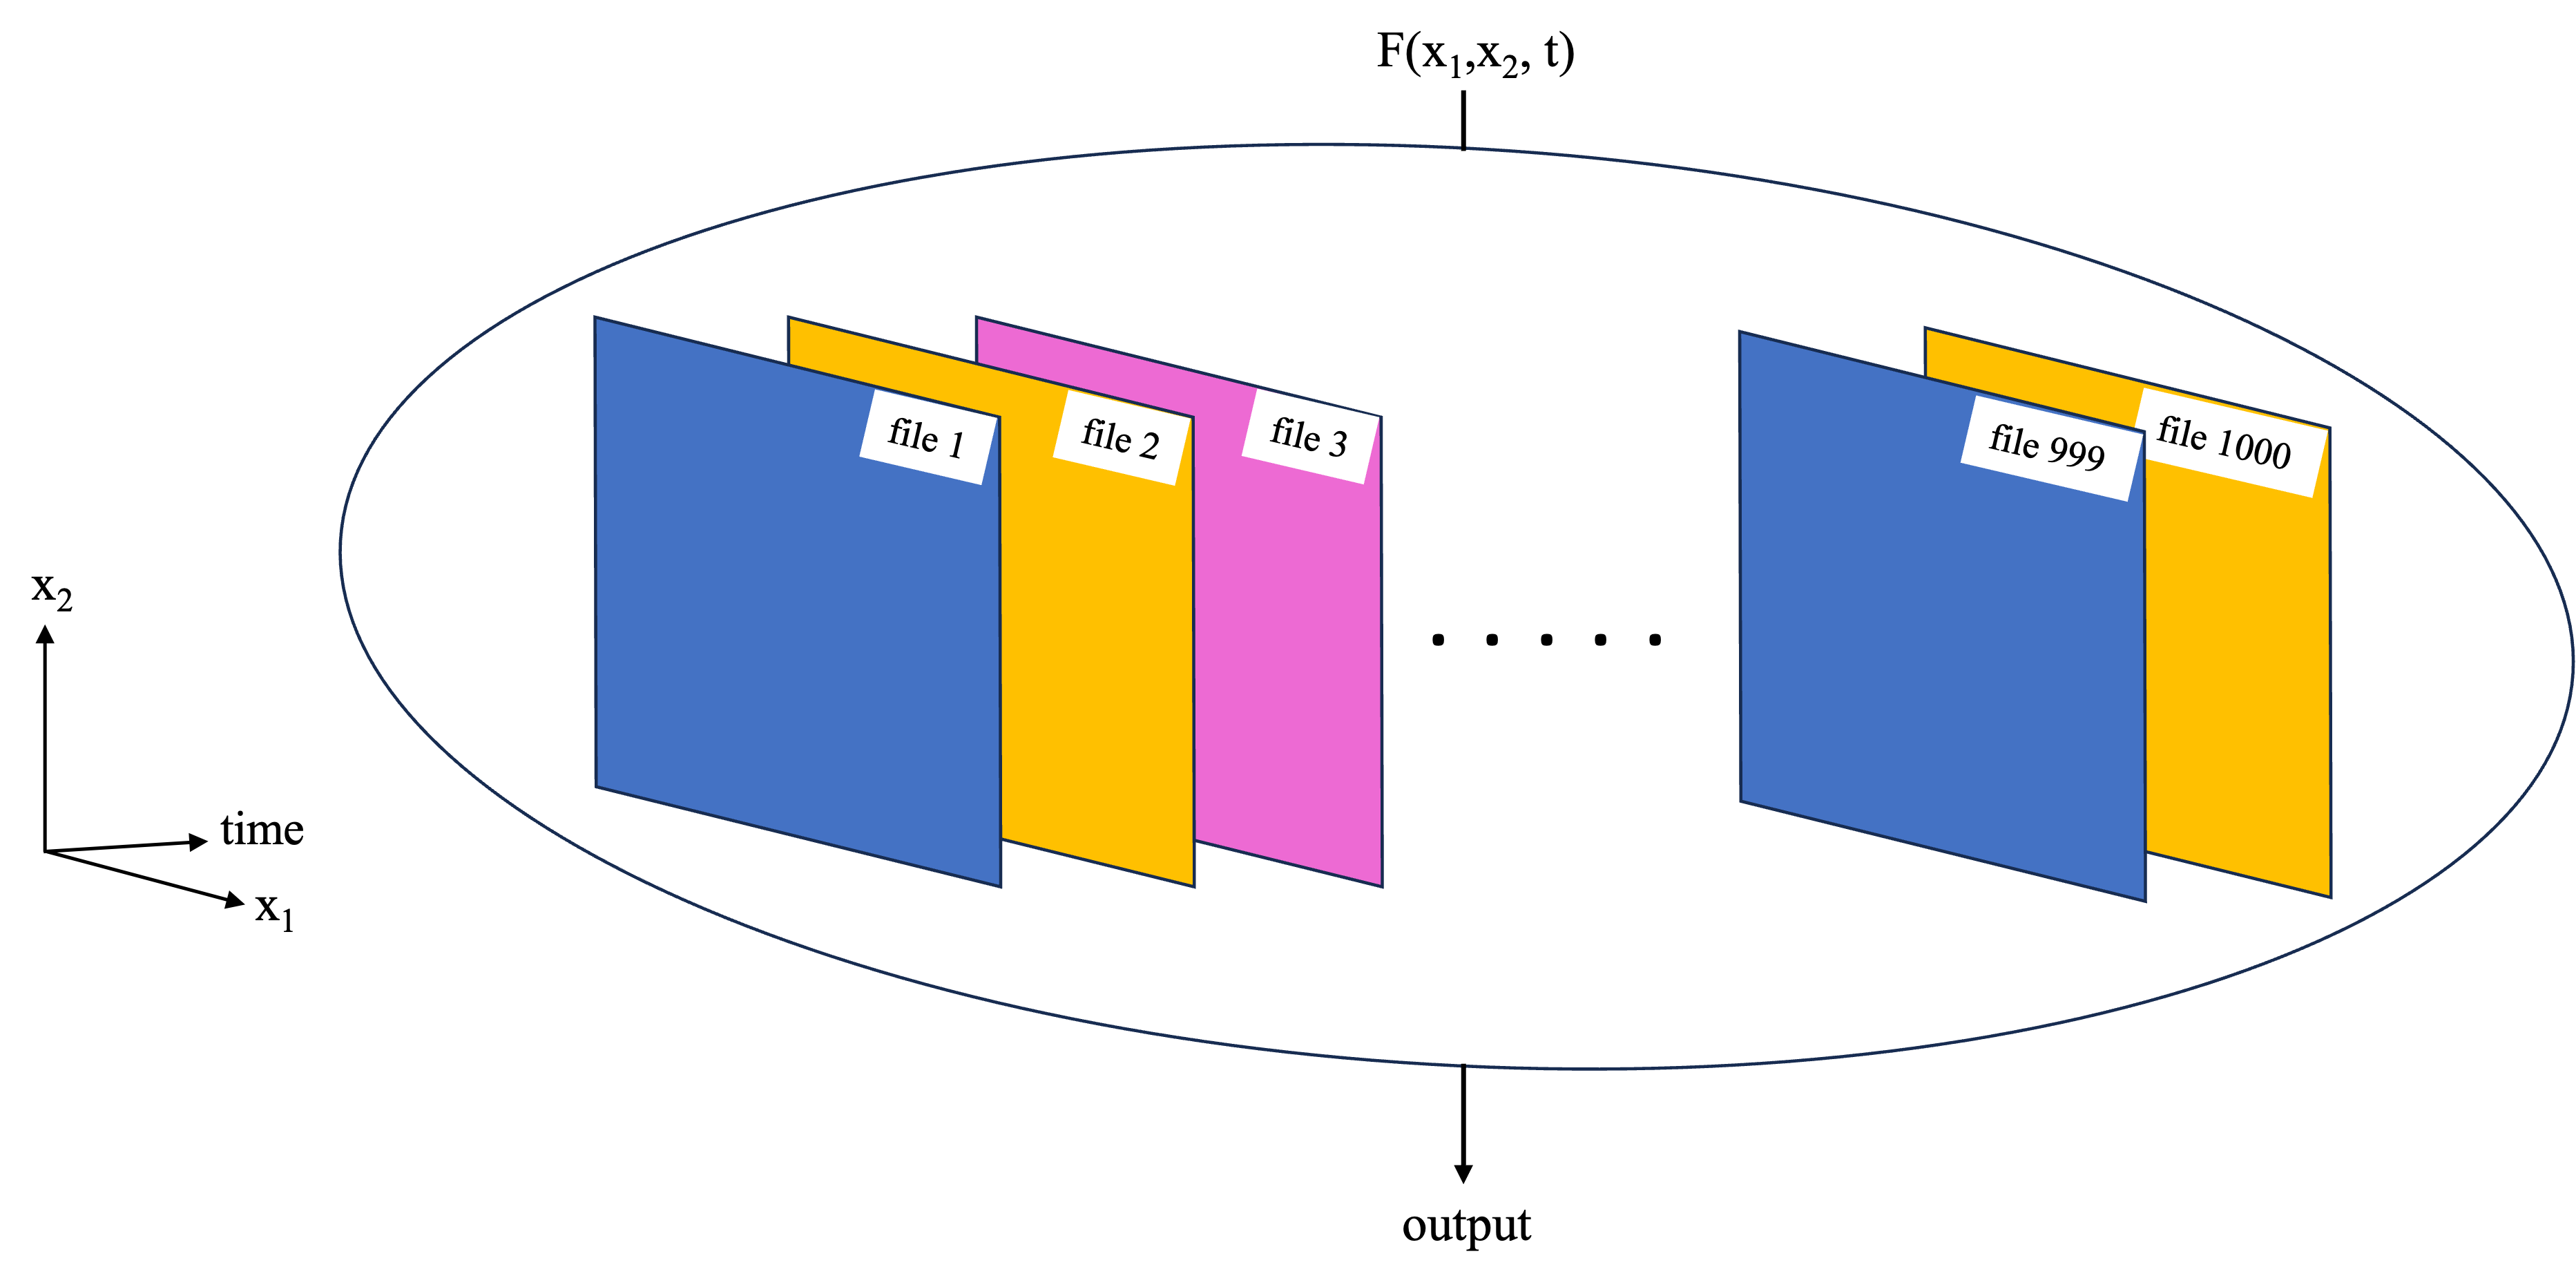

### User knowledge and learning outcomes
#### Prerequisite knowledge
...
#### What these notebooks cover
Local clusters...
#### What these notbook do not cover
Remote clusters... (distributed clusters?)

In [1]:
import earthaccess

import xarray as xr
from dask.distributed import Client, LocalCluster

import matplotlib.pyplot as plt
%matplotlib inline

## 1. Locate data file endpoints

This section covers two methods for locating S3 endpoints for the MUR SST files (which will be passed to Xarray to access the data). The first uses the `s3fs` package and the second uses the `earthaccess` package. The `earthaccess` package will likely gain more popularity in the future so users are steared toward it.

### 1.1 `s3fs` method

In [19]:
# Connect to AWS S3 File System and Locate MUR 1 km File Paths:
creds = requests.get('https://archive.podaac.earthdata.nasa.gov/s3credentials').json() # temp credentials for Earthdata access on AWS
fs_s3 = s3fs.S3FileSystem(
    anon=False,
    key=creds['accessKeyId'],
    secret=creds['secretAccessKey'], 
    token=creds['sessionToken'],
    client_kwargs={'region_name':'us-west-2'}
    )
s3path = "s3://podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/"
fns = fs_s3.glob(s3path+"*.nc")

In [3]:
# Check that S3 connection was successful:
print("total files found = ",len(fns))
print("Example filename: ", fns[0])

total files found =  7721
Example filename:  podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20020601090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc


### 1.2 `earthaccess` method

In [2]:
#...

In [3]:
#...

## 2. Compute the global mean for a single file

Load and inspect the file

In [24]:
s3_file_obj = fs_s3.open(fns[0], mode='rb')
data = xr.open_dataset(s3_file_obj)
data 

<xarray.Dataset>
Dimensions:           (time: 1, lat: 17999, lon: 36000)
Coordinates:
  * time              (time) datetime64[ns] 2002-06-01T09:00:00
  * lat               (lat) float32 -89.99 -89.98 -89.97 ... 89.97 89.98 89.99
  * lon               (lon) float32 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
Data variables:
    analysed_sst      (time, lat, lon) float32 ...
    analysis_error    (time, lat, lon) float32 ...
    mask              (time, lat, lon) float32 ...
    sea_ice_fraction  (time, lat, lon) float32 ...
Attributes: (12/47)
    Conventions:                CF-1.5
    title:                      Daily MUR SST, Final product
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    references:                 http://podaac.jpl.nasa.gov/Multi-scale_Ultra-...
    institution:                Jet Propulsion Laboratory
    history:                    created at nominal 4-day latency; replaced nr...
    ...                         ...
    project:                    NASA Making Earth Science Data Records for Us...
    publisher_name:             GHRSST Project Office
    publisher_url:              http://www.ghrsst.org
    publisher_email:            ghrsst-po@nceo.ac.uk
    processing_level:           L4
    cdm_data_type:              grid

In [9]:
%%time
print(data['analysed_sst'].mean().values)
data.close()

286.75073
CPU times: user 8.32 s, sys: 1.99 s, total: 10.3 s
Wall time: 24 s


## Compute the global mean of the first 10 files in serial with a for-loop

This is an example of how not to use xarray, especially if trying to implement parallel computing with it:

In [6]:
%%time

globalmeansst = []
time = []
for f in fns[:10]:
    s3_file_object = fs_s3.open(f, mode='rb')
    data = xr.open_dataset(s3_file_object)
    time.append(data['time'].values)
    globalmeansst.append(data['analysed_sst'].mean().values)

CPU times: user 1min 31s, sys: 29.8 s, total: 2min 1s
Wall time: 4min 33s


In [9]:
globalmeansst

[<xarray.DataArray 'analysed_sst' ()>
 array(286.75073, dtype=float32),
 <xarray.DataArray 'analysed_sst' ()>
 array(286.78214, dtype=float32),
 <xarray.DataArray 'analysed_sst' ()>
 array(286.78564, dtype=float32),
 <xarray.DataArray 'analysed_sst' ()>
 array(286.7816, dtype=float32),
 <xarray.DataArray 'analysed_sst' ()>
 array(286.7549, dtype=float32),
 <xarray.DataArray 'analysed_sst' ()>
 array(286.72464, dtype=float32),
 <xarray.DataArray 'analysed_sst' ()>
 array(286.70187, dtype=float32),
 <xarray.DataArray 'analysed_sst' ()>
 array(286.67288, dtype=float32),
 <xarray.DataArray 'analysed_sst' ()>
 array(286.65546, dtype=float32),
 <xarray.DataArray 'analysed_sst' ()>
 array(286.64944, dtype=float32)]

## Compute global mean of the first 10 files using xarray's `open_mfdataset()` functionality

This type of syntax will allow us to use xarray with dask parallelization. As a first step, we do not implement parallelization, but show how `open_mfdataset` is used to perform the same task as above without the for-loop.

In [41]:
# Gather data from all 10 files:
s3_file_objects = [ fs_s3.open(fns[i], mode='rb') for i in range(10) ]
data_mf = xr.open_mfdataset(s3_file_objects)
data_mf

<xarray.Dataset>
Dimensions:           (time: 10, lat: 17999, lon: 36000)
Coordinates:
  * time              (time) datetime64[ns] 2002-06-01T09:00:00 ... 2002-06-1...
  * lat               (lat) float32 -89.99 -89.98 -89.97 ... 89.97 89.98 89.99
  * lon               (lon) float32 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
Data variables:
    analysed_sst      (time, lat, lon) float32 dask.array<chunksize=(1, 17999, 36000), meta=np.ndarray>
    analysis_error    (time, lat, lon) float32 dask.array<chunksize=(1, 17999, 36000), meta=np.ndarray>
    mask              (time, lat, lon) float32 dask.array<chunksize=(1, 17999, 36000), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float32 dask.array<chunksize=(1, 17999, 36000), meta=np.ndarray>
Attributes: (12/47)
    Conventions:                CF-1.5
    title:                      Daily MUR SST, Final product
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    references:                 http://podaac.jpl.nasa.gov/Multi-scale_Ultra-...
    institution:                Jet Propulsion Laboratory
    history:                    created at nominal 4-day latency; replaced nr...
    ...                         ...
    project:                    NASA Making Earth Science Data Records for Us...
    publisher_name:             GHRSST Project Office
    publisher_url:              http://www.ghrsst.org
    publisher_email:            ghrsst-po@nceo.ac.uk
    processing_level:           L4
    cdm_data_type:              grid

Then compute mean over the spatial coordinates, which will give us the global mean for each time step:

In [ ]:
%%time

data_mf['analysed_sst'].mean(dim=['lat','lon']).load()

In [46]:
del data_mf

## Compute global mean of the first 10 files using xarray's `open_mfdataset()` functionality and dask's parallel processing

For simple built in functions such as `xarray`'s `mean()`, the switch over to parallel processing is straightforward. All that needs to be done is adding a few lines before the data processing code, which starts a computing cluster and a 'client'. You can specify things like number of workers if you are familiar, otherwise, they will start up with some default settings.

In [44]:
cluster = LocalCluster()
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 48,Total memory: 373.71 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46275,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 48
Started: Just now,Total memory: 373.71 GiB
Comm: tcp://127.0.0.1:42825,Total threads: 6
Dashboard: http://127.0.0.1:44823/status,Memory: 46.71 GiB
Nanny: tcp://127.0.0.1:38117,


Then run the same processing code as in the previous section:

In [47]:
%%time

s3_file_objects = [ fs_s3.open(fns[i], mode='rb') for i in range(10) ]
data_mf = xr.open_mfdataset(s3_file_objects)
data_mf['analysed_sst'].mean(dim=['lat','lon']).load()

CPU times: user 3.58 s, sys: 746 ms, total: 4.33 s
Wall time: 55.5 s


<xarray.DataArray 'analysed_sst' (time: 10)>
array([286.75375, 286.78516, 286.78864, 286.78458, 286.75793, 286.72763,
       286.70486, 286.67587, 286.65845, 286.65244], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2002-06-01T09:00:00 ... 2002-06-10T09:00:00

In [48]:
del data_mf
client.close()
cluster.close()

## Global Mean of the First 10 Files with Additional Chunking

If you create a large number of workers such that each one does not have enough memory to process an entire file, you can specify smaller chunks:

In [ ]:
cluster = LocalCluster()
client = Client(cluster)
client

In [49]:
s3_file_objects = [ fs_s3.open(fns[i], mode='rb') for i in range(10) ]
data_mf_chunked = xr.open_mfdataset(s3_file_objects, chunks={'time':1, 'lat':3000, 'lon':3000})
data_mf_chunked['analysed_sst']

<xarray.DataArray 'analysed_sst' (time: 10, lat: 17999, lon: 36000)>
dask.array<concatenate, shape=(10, 17999, 36000), dtype=float32, chunksize=(1, 3000, 3000), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2002-06-01T09:00:00 ... 2002-06-10T09:00:00
  * lat      (lat) float32 -89.99 -89.98 -89.97 -89.96 ... 89.97 89.98 89.99
  * lon      (lon) float32 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
Attributes:
    long_name:      analysed sea surface temperature
    standard_name:  sea_surface_foundation_temperature
    units:          kelvin
    valid_min:      -32767
    valid_max:      32767
    comment:        "Final" version using Multi-Resolution Variational Analys...
    source:         AMSRE-REMSS, AVHRR_Pathfinder-PFV5.2-NODC_day, AVHRR_Path...

In [30]:
%%time

data_mf_chunked['analysed_sst'].mean(dim=['lat','lon']).load()

CPU times: user 3.3 s, sys: 193 ms, total: 3.5 s
Wall time: 24.8 s


<xarray.DataArray 'analysed_sst' (time: 5)>
array([286.77762, 286.80923, 286.81274, 286.80914, 286.78253],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2002-06-01T09:00:00 ... 2002-06-05T09:00:00

In [50]:
del data_mf_chunked
client.close()
cluster.close()

## Mean Over a Region of the Globe

Dask works with Xarray such that multiple functions can be strung together, and then a single `load()` function is called to computed everything. In this example, the mean over a region is taken by first subsetting all data to that region ("function 1") and then taking the mean over that region ("function 2").

In [75]:
cluster = LocalCluster()
client = Client(cluster)

In [76]:
s3_file_objects = [ fs_s3.open(fns[i], mode='rb') for i in range(10) ]
data_mf = xr.open_mfdataset(s3_file_objects)

In [72]:
results = data_mf['analysed_sst'].sel(lat=slice(-45,45), lon=slice(-180, -50)) # subset
results = results.mean(dim=['lat','lon']) # mean

In [73]:
%%time

regionalmean = results.load()
regionalmean

CPU times: user 833 ms, sys: 84.6 ms, total: 917 ms
Wall time: 12.3 s


<xarray.DataArray 'analysed_sst' (time: 10)>
array([295.84003, 295.85287, 295.8525 , 295.8382 , 295.78757, 295.75385,
       295.7241 , 295.6926 , 295.67197, 295.6628 ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2002-06-01T09:00:00 ... 2002-06-10T09:00:00

In [77]:
del data_mf
client.close()
cluster.close()

## Optimizing

Some additional notes on chunking from https://docs.dask.org/en/latest/array-chunks.html

For performance, a good choice of chunks follows the following rules:

* A chunk should be small enough to fit comfortably in memory. We’ll have many chunks in memory at once
* A chunk must be large enough so that computations on that chunk take significantly longer than the 1ms overhead per task that Dask scheduling incurs. A task should take longer than 100ms
* Chunk sizes between 10MB-1GB are common, depending on the availability of RAM and the duration of computations
* Chunks should align with the computation that you want to do.
* For example, if you plan to frequently slice along a particular dimension, then it’s more efficient if your chunks are aligned so that you have to touch fewer chunks. If you want to add two arrays, then its convenient if those arrays have matching chunks patterns
* Chunks should align with your storage, if applicable.
* Array data formats are often chunked as well. When loading or saving data, if is useful to have Dask array chunks that are aligned with the chunking of your storage, often an even multiple times larger in each direction
* Learn more in Choosing good chunk sizes in Dask by Genevieve Buckley.


Modern NDArray storage formats like HDF5, NetCDF, TIFF, and Zarr, allow arrays to be stored in chunks or tiles so that blocks of data can be pulled out efficiently without having to seek through a linear data stream. It is best to align the chunks of your Dask array with the chunks of your underlying data store.

However, data stores often chunk more finely than is ideal for Dask array, so it is common to choose a chunking that is a multiple of your storage chunk size, otherwise you might incur high overhead.

For example, if you are loading a data store that is chunked in blocks of (100, 100), then you might choose a chunking more like (1000, 2000) that is larger, but still evenly divisible by (100, 100). Data storage technologies will be able to tell you how their data is chunked.

In [21]:
s3_file_objects = [ fs_s3.open(fns[i], mode='rb') for i in range(10) ]
#data_mf_chunked = xr.open_mfdataset(s3_file_objects)
data_mf_chunked = xr.open_mfdataset(s3_file_objects, chunks={'time':1, 'lat':3000, 'lon':6000})
data_mf_chunked['analysed_sst']

<xarray.DataArray 'analysed_sst' (time: 10, lat: 17999, lon: 36000)>
dask.array<concatenate, shape=(10, 17999, 36000), dtype=float32, chunksize=(1, 3000, 6000), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2002-06-01T09:00:00 ... 2002-06-10T09:00:00
  * lat      (lat) float32 -89.99 -89.98 -89.97 -89.96 ... 89.97 89.98 89.99
  * lon      (lon) float32 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
Attributes:
    long_name:      analysed sea surface temperature
    standard_name:  sea_surface_foundation_temperature
    units:          kelvin
    valid_min:      -32767
    valid_max:      32767
    comment:        "Final" version using Multi-Resolution Variational Analys...
    source:         AMSRE-REMSS, AVHRR_Pathfinder-PFV5.2-NODC_day, AVHRR_Path...

In [15]:
cluster = LocalCluster(n_workers=128)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 128
Total threads: 128,Total memory: 247.85 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42497,Workers: 128
Dashboard: http://127.0.0.1:8787/status,Total threads: 128
Started: Just now,Total memory: 247.85 GiB
Comm: tcp://127.0.0.1:33309,Total threads: 1
Dashboard: http://127.0.0.1:45425/status,Memory: 1.94 GiB
Nanny: tcp://127.0.0.1:40883,


In [5]:
%%time

s3_file_objects = [ fs_s3.open(fns[i], mode='rb') for i in range(50) ]
data_mf_chunked = xr.open_mfdataset(s3_file_objects, chunks={'time':1, 'lat':3000, 'lon':6000})

results = data_mf_chunked['analysed_sst'].mean(dim=['lat','lon'])
results.load()

CPU times: user 31.2 s, sys: 13.1 s, total: 44.4 s
Wall time: 55.8 s


<xarray.DataArray 'analysed_sst' (time: 50)>
array([286.77747, 286.809  , 286.81247, 286.80893, 286.78232, 286.75262,
       286.7293 , 286.69965, 286.68134, 286.67657, 286.68683, 286.6907 ,
       286.69675, 286.719  , 286.7409 , 286.77347, 286.8111 , 286.83453,
       286.83966, 286.83984, 286.83582, 286.82587, 286.81464, 286.80826,
       286.80353, 286.79977, 286.7994 , 286.81784, 286.81726, 286.81073,
       286.81223, 286.82745, 286.8074 , 286.78214, 286.7656 , 286.76166,
       286.7737 , 286.7866 , 286.79495, 286.8004 , 286.8213 , 286.84366,
       286.86526, 286.88675, 286.8983 , 286.90506, 286.91742, 286.86392,
       286.86987, 286.8648 ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2002-06-01T09:00:00 ... 2002-07-20T09:00:00

In [21]:
%%time

def testmean(data):
    return data.mean(dim=['lat','lon'])

s3_file_objects = [ fs_s3.open(fns[i], mode='rb') for i in range(200) ]
data_mf_chunked = xr.open_mfdataset(s3_file_objects, chunks={'time':1, 'lat':6000, 'lon':6000})

results = data_mf_chunked['analysed_sst'].mean(dim=['lat','lon'])
results.load()

CPU times: user 58.1 s, sys: 15.5 s, total: 1min 13s
Wall time: 1min 51s
